In [1]:
import numpy as np
from scipy.linalg import eigh
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import silhouette_score
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, random_split
from tqdm.notebook import tqdm, trange
import torch.nn.functional as F
import torch.nn as nn
import torch
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
import os
import faiss
import json

torch.manual_seed(42)

In [2]:
k = os.getenv("K", 192)

PRF_KEY = int(os.getenv("PRF_KEY", 42))
LABELING = os.getenv("LABELING", "kmeans")
ROOT_DIR = os.getenv("ROOT_DIR", "..")


model_name = os.getenv("MODEL", "meta-llama/Llama-2-7b-hf")
# model_name = os.getenv("MODEL", "mistral/Mistral-7B-v0.3")

assert LABELING in ["kmeans", "rand_proj"]


k = int(k)
print(f"K: {k}")

K: 192


In [3]:
dataset_name = "Skylion007/openwebtext"
model_suffix = model_name.split("/")[-1]
dataset_suffix = dataset_name.split("/")[-1]
dir = f"{ROOT_DIR}/data/{dataset_suffix}_{model_suffix}"
model_dir = f"{ROOT_DIR}/saved_models/{dataset_suffix}_{model_suffix}"
hidden_states = torch.load(f"{dir}/hidden_states.pt")

hidden_states = hidden_states.float()
print(f"Hidden states shape: {hidden_states.shape}")

Hidden states shape: torch.Size([1500000, 4096])


In [4]:
def ridge_regression(X, Y, alpha):
    """Performs ridge regression to find the weights W such that Y = X @ W + noise.
    Args:
        X (torch.Tensor): Hidden states
        Y (torch.Tensor): One-hot encoded labels
        alpha (float): Regularization strength."""
    d_in = X.shape[1]
    I = torch.eye(d_in, device=X.device)
    W = torch.linalg.solve(X.T @ X + alpha * I, X.T @ Y)
    return W

def linear_selector(X, y, alpha=1e-3, sharpen=10.0):
    """
    X: [N, D] raw hidden states
    y: [N] integer labels 0…K‑1
    returns W: [D, K] selector matrix (pure linear map)
    """
    N, D = X.shape
    K = int(y.max()) + 1
    Y = F.one_hot(y, K).float()

    XtX = X.T @ X
    lam = alpha * XtX.trace() / D
    W = torch.linalg.solve(XtX + lam * torch.eye(D, device=X.device), X.T @ Y)

    # Sharpen
    logits = X @ W
    per_class_max = logits.amax(dim=0, keepdim=True)
    W = W / per_class_max.clamp_min(1e-8) * sharpen

    return W

def ols(X, Y):
    return torch.linalg.lstsq(X, Y).solution

In [5]:
def generate_rand_proj_labels(prf_key, k):
    rng = torch.Generator()
    rng.manual_seed(prf_key)
    W_random, _ = torch.linalg.qr(torch.randn(
        hidden_states.shape[1], k, generator=rng))
    logits = F.linear(hidden_states, W_random.T)
    all_labels = torch.argmax(logits, dim=1)
    return all_labels


def generate_kmeans_labels_new(prf_key, k):
    kmeans_input = hidden_states
    index = faiss.IndexFlatL2(kmeans_input.shape[1])  # Euclidean

    # Convert to float32 numpy
    data_np = kmeans_input.cpu().numpy().astype('float32')

    # Build kmeans object
    kmeans = faiss.Clustering(
        data_np.shape[1],
        k
    )
    kmeans.niter = 200
    kmeans.seed = prf_key

    # Train and get labels
    kmeans.train(data_np, index)
    _, labels = index.search(data_np, 1)

    all_labels = torch.tensor(
        labels.squeeze(), device=hidden_states.device, dtype=torch.long)
    centroids = torch.tensor(
        faiss.vector_to_array(kmeans.centroids), device=hidden_states.device, dtype=torch.float32)
    return all_labels, centroids


def generate_kmeans_labels(prf_key, k, hidden_states):
    kmeans = MiniBatchKMeans(
        n_clusters=k, random_state=prf_key, init="k-means++", batch_size=8192*10, max_iter=150)
    # # # Normalize because cosine distance matters for for aligned vectors
    # hidden_states = torch.nn.functional.normalize(
    #     hidden_states, dim=1)

    kmeans.fit(hidden_states.cpu().numpy())
    all_labels = kmeans.labels_
    all_labels = torch.tensor(
        all_labels, device=hidden_states.device, dtype=torch.long)
    centroids = torch.tensor(
        kmeans.cluster_centers_, device=hidden_states.device, dtype=torch.float32)
    return all_labels, centroids

In [6]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score


def compare_label_stability(method, prf_key1, prf_key2):
    labels1 = method(prf_key1, 16).cpu().numpy()
    labels2 = method(prf_key2, 16).cpu().numpy()

    ari = adjusted_rand_score(labels1, labels2)
    nmi = normalized_mutual_info_score(labels1, labels2)

    print(f"{method.__name__} - ARI: {ari:.4f}, NMI: {nmi:.4f}")

In [7]:
def clean(all_labels, all_hidden_states, min_size=100):
    """
    Removes small clusters and filters corresponding hidden states.

    Args:
        all_labels (torch.LongTensor): Tensor of shape (N,) with cluster labels.
        all_hidden_states (torch.Tensor): Tensor of shape (N, D), hidden states.
        min_size (int): Minimum number of samples to keep a cluster.

    Returns:
        new_labels (torch.LongTensor): Reindexed cluster labels (contiguous).
        new_hidden_states (torch.Tensor): Filtered hidden states.
    """
    device = all_labels.device
    max_label = all_labels.max().item()

    # Count members in each cluster
    label_counts = torch.bincount(all_labels, minlength=max_label + 1)

    # Identify valid clusters
    valid_mask = label_counts >= min_size
    valid_labels = torch.nonzero(valid_mask).squeeze(1)

    # Create remapping: old label → new label (contiguous), invalid → -1
    mapping = -torch.ones(max_label + 1, dtype=torch.long, device=device)
    mapping[valid_labels] = torch.arange(valid_labels.size(0), device=device)

    # Remap all labels (invalid → -1)
    remapped_labels = mapping[all_labels]

    # Mask for valid entries
    valid_idx = remapped_labels != -1
    filtered_labels = remapped_labels[valid_idx]
    filtered_hidden_states = all_hidden_states[valid_idx]

    return filtered_labels, filtered_hidden_states

In [8]:

PRF_KEY = PRF_KEY % 2**64
if LABELING == "kmeans":
    all_labels, centroids = generate_kmeans_labels(PRF_KEY, k, hidden_states)
    all_labels, hidden_states = clean(all_labels, hidden_states, min_size=10)
    k = all_labels.max().item() + 1

    print(f"Reduced number of classes: {k}")
elif LABELING == "rand_proj":
    all_labels = generate_rand_proj_labels(PRF_KEY, k)

Reduced number of classes: 182


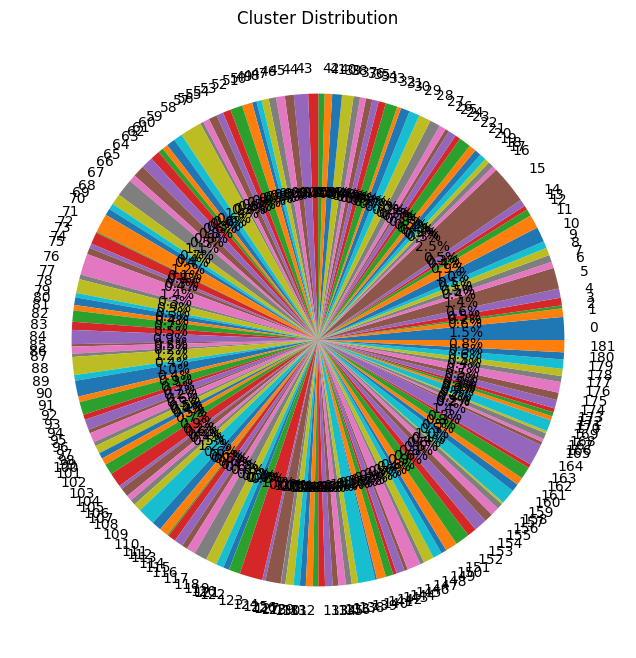

[22465  8340  2886  7543  9087 20575  6200  6937  7466  6877 14675 13520
  6666  4228  6834 37749  4456  5490  4713  6508  6432  6993 11705  5219
  7635  3920  6568 10195 11958 10215  8853  3891 11584  7113  6371  6286
  5794  6404 11292    15  9518  7399  6092  9906 14032  8734  8621  7253
  6877  5213  4452 10005 12050  7658  6838  8154  6154  3386 21105  8548
  8646  5485  5104  9482 11451 11712  6856 17199 10733  5882  6583 18579
  1025 11632  4483  6404 20780  4736 13647  4362  7423  5383 10990  7928
 13824  2348  7009  3162 17667  5597 15585  5531 12757  5146 10181  3719
  9404  4101  7785    57  5835  6774 10502 14214  3473  8777  5519  5386
  7727 17316  9525  8882  1422  7687  8581  5568  8664 12694 10763  7520
  5788    25 11252 22556  3119 15026   190  4382  7932  6194  5771  6822
  5470  6453  7416  5610  7280  5756  6294 16856  1678  8941  7404  3541
  8104  3340 13166  4093 10148  8938  5330 11832 14138  8987 12665  8604
  8375  5793  1875 14661  7635  7496 11980  3768 21

In [9]:
# Plot counts of each cluster as pie chart
unique, counts = torch.unique(all_labels, return_counts=True)
counts = counts.cpu().numpy()
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=unique.cpu().numpy(), autopct='%1.1f%%')
plt.title("Cluster Distribution")
plt.show()


print(counts)

In [10]:

# Create a dataset with the labels
dataset = TensorDataset(hidden_states, all_labels)
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_indices = train_dataset.indices
val_indices = val_dataset.indices
train_hidden_states = hidden_states[train_indices]
train_labels = all_labels[train_indices]

# create a downsampled dataset from the train dataset
train_hidden_states_downsampled = []
train_labels_downsampled = []
for i in range(k):
    class_indices = (train_labels == i).nonzero(as_tuple=True)[0]
    class_data = train_hidden_states[class_indices]
    # Sample min(samples_per_class, available samples)
    sampled_indices = class_indices[torch.randperm(
        len(class_data))[:min(30000, len(class_data))]]
    train_hidden_states_downsampled.append(
        hidden_states[sampled_indices])
    train_labels_downsampled.append(all_labels[sampled_indices])
train_hidden_states_downsampled = torch.cat(
    train_hidden_states_downsampled)
train_labels_downsampled = torch.cat(
    train_labels_downsampled)


val_hidden_states = hidden_states[val_indices]
val_labels = all_labels[val_indices]


print(f"Train size: {train_size}, Val size: {val_size}")
# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=128,
                              shuffle=True, num_workers=1)
val_dataloader = DataLoader(
    val_dataset, batch_size=128, shuffle=False)

Train size: 1124982, Val size: 374994


In [11]:
def train_sparse_selector(train_loader, D, K, epochs=5, beta=0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    layer = torch.nn.Linear(D, K, bias=False).to(device)
    opt = torch.optim.Adam(layer.parameters(), lr=1e-3)

    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in tqdm(train_loader):
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = layer(xb)
            ce_loss = F.cross_entropy(logits, yb)
            l1_loss = logits.abs().mean()
            loss = ce_loss + beta * l1_loss
            loss.backward()
            opt.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} loss: {total_loss / len(train_loader):.4f}")

    return layer.weight.detach().cpu().T

In [12]:
# W = train_sparse_selector(train_dataloader, D=train_hidden_states.size(1), K=k, beta=1)


In [13]:

def rescale(final_matrix, X_train_dataset, X_train_labels):
    X_projected = F.linear(X_train_dataset, final_matrix)
    max_values, max_indices = torch.max(X_projected, dim=1)
    cluster_max_means = []
    for i in range(k):
        values = max_values[X_train_labels == i]
        assert len(values) > 0, f"Cluster {i} is empty"
        cluster_max_means.append(values.mean())

    cluster_max_means = torch.tensor(
        cluster_max_means, device=final_matrix.device).pow(-1)
    cluster_max_means = torch.diag(cluster_max_means)
    final_matrix = cluster_max_means @ final_matrix
    return final_matrix


def compute_accuracy(final_matrix, X, y_true):
    X_projected = F.linear(X, final_matrix)
    y_pred = torch.argmax(X_projected, dim=1)
    accuracy = (y_pred == y_true).float().mean().item()
    return accuracy


def post_process(selector_matrix, rescale_mat=True):
    if rescale_mat:
        final_matrix = rescale(selector_matrix, train_hidden_states_downsampled, train_labels_downsampled)
    else:
        final_matrix = selector_matrix
    train_accuracy = compute_accuracy(
        final_matrix, train_hidden_states_downsampled, train_labels_downsampled)
    val_accuracy = compute_accuracy(
        final_matrix, val_hidden_states, val_labels)
    print(
        f"Train Accuracy: {train_accuracy:.4f} Val Accuracy: {val_accuracy:.4f}")
    return final_matrix

In [14]:
# Create one hot encoding of train_labels
train_labels_one_hot = torch.zeros(
    train_labels.size(0), k)
train_labels_one_hot.scatter_(1, train_labels.unsqueeze(1), 1)
train_labels_one_hot = train_labels_one_hot.float()


W = ridge_regression(
    train_hidden_states, train_labels_one_hot, alpha=1e-3)


# Assert that W does not have NaN values
assert not torch.isnan(W).any(), "W has NaN values"

final_matrix = post_process(W.T)

assert not torch.isnan(final_matrix).any(), "Post processed W has NaN values"


Train Accuracy: 0.6147 Val Accuracy: 0.6053


Visualize selectors

In [15]:
X_sample_projected = F.linear(val_hidden_states, final_matrix)


In [16]:
def measure_one_hotness(
    logits: torch.Tensor,
    labels: torch.Tensor | None = None,
    p: int = 1,
) -> dict:
    """Quantify how close a batch of *logits* is to perfect one‑hot selectors.

    Metrics returned
    ---------------
    l{p}_error : float
        Mean ℓₚ distance between ``logits`` and the closest *true* one‑hot vector
        (requires ``labels``).  For ``p=1`` this is mean absolute error.
    top1_accuracy : float | None
        Fraction where ``argmax(logits) == labels`` (only if labels given).
    mean_gap : float
        Mean (winner – runner‑up) difference per sample.
    sharpness : float
        Mean ratio winner / (sum of losers).  High = more one‑hot‑like.
    """
    if logits.ndim < 2:
        raise ValueError("logits must have shape [..., K]")

    # Flatten leading dims so we operate on 2‑D [N, K]
    N = logits.shape[:-1].numel()
    K = logits.shape[-1]
    logits2d = logits.reshape(N, K)

    # winner & runner‑up
    top2 = logits2d.topk(2, dim=1).values        # [N, 2]
    winner = top2[:, 0]
    runner_up = top2[:, 1]
    mean_gap = (winner - runner_up).mean().item()

    sharpness = (winner / (logits2d.sum(dim=1) - winner + 1e-8)).mean().item()

    results = {
        f"l{p}_error": None,
        "top1_accuracy": None,
        "mean_gap": mean_gap,
        "sharpness": sharpness,
    }

    if labels is not None:
        if labels.numel() != N:
            raise ValueError("labels must have the same number of elements as logits rows")
        if labels.ndim != 1:
            labels = labels.view(-1)
        one_hot = F.one_hot(labels.to(torch.long), num_classes=K).to(dtype=logits.dtype)
        diff = logits2d - one_hot
        if p == 1:
            err = diff.abs().mean().item()
        elif p == 2:
            err = diff.pow(2).mean().sqrt().item()
        else:
            err = diff.abs().pow(p).mean().pow(1.0 / p).item()
        results[f"l{p}_error"] = err
        results["top1_accuracy"] = (logits2d.argmax(dim=1) == labels).float().mean().item()

    return results


# Measure one-hotness of the selector matrix
one_hotness_metrics = measure_one_hotness(
    X_sample_projected,
    labels=val_labels,
    p=1)

print("One-hotness metrics:")
for metric, value in one_hotness_metrics.items():
    print(f"{metric}: {value:.4f}") 

One-hotness metrics:
l1_error: 0.0678
top1_accuracy: 0.6053
mean_gap: 0.3048
sharpness: 0.4334


In [17]:
import sys 
sys.path.append('/data/users/miroojin/saksham/watermark-adapters')


from src.mbmark import MbMark

watermark_matrix = MbMark._make_watermarking_matrix(32000, 2, 0.1, seed=PRF_KEY, n_clusters=k)


# Count ones in every row of the watermark matrix
ones_count = watermark_matrix.sum(dim=1)

ones_count_mean = ones_count.mean()







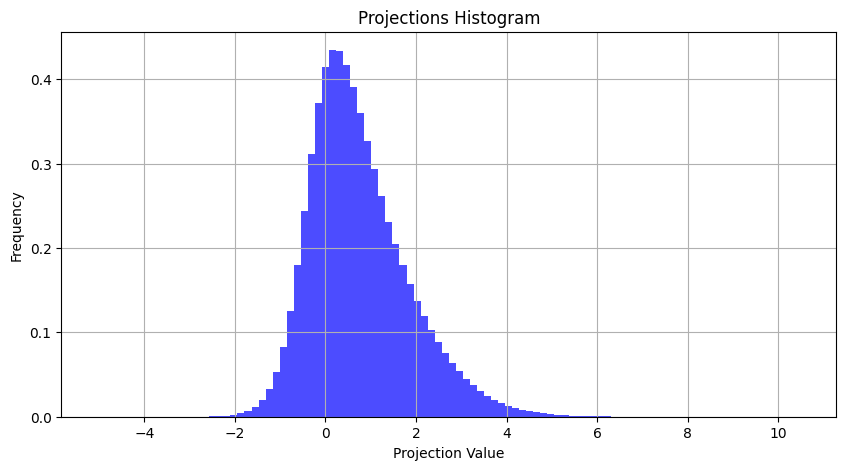

In [18]:

delta_w =  watermark_matrix @ final_matrix

delta_w  = delta_w 

delta_w.shape

projections = F.linear(val_hidden_states[:5000], delta_w)

# Plot projections histogram
plt.figure(figsize=(10, 5))
plt.hist(projections.cpu().numpy().flatten(), density=True, bins=100, alpha=0.7, color='blue')
plt.title('Projections Histogram')
plt.xlabel('Projection Value')
plt.ylabel('Frequency')
plt.grid()
plt.show()

Save model

In [19]:
# Save the final matrix to model_dir with k
output_file = f"{model_dir}/selector_matrix_k{k}.pth"
torch.save(final_matrix, output_file)